In [29]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import AnchorImage

In [30]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


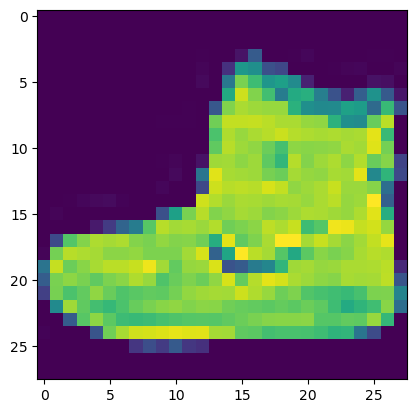

In [31]:
idx = 0
plt.imshow(x_train[idx]);

In [32]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [33]:
x_in = Input(shape=(28, 28, 1))
x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x_out = Dense(10, activation='softmax')(x)
cnn = Model(inputs=x_in, outputs=x_out)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=10)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_98 (Conv2D)          (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_99 (Conv2D)          (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                       

In [34]:
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.909500002861023


In [35]:
def superpixel(image, size=(4, 7)):
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    #print(row_idx, col_idx)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments

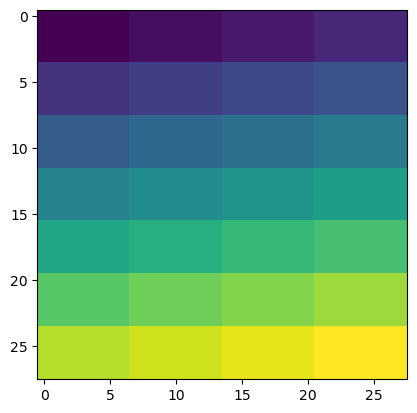

In [36]:
segments = superpixel(x_train[idx])
plt.imshow(segments)

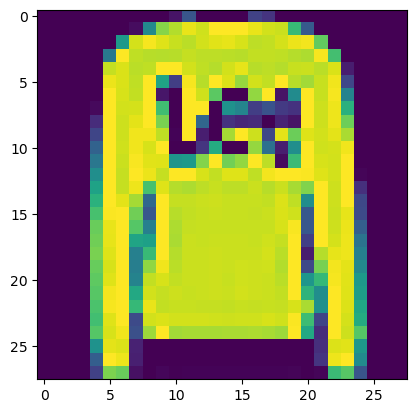

In [37]:
i = 1
image = x_test[i]
plt.imshow(image[:,:,0])

In [38]:
predict_fn = lambda x: cnn.predict(x)

image_shape = x_test[i].shape
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=superpixel)

1/1 [==============================] - 0s 46ms/step


In [39]:
explanation = explainer.explain(image, threshold=.95, p_sample=.8, seed=0)

4/4 [==============================] - 0s 5ms/step


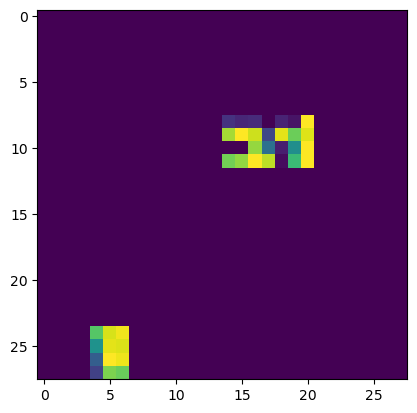

In [40]:
plt.imshow(explanation.anchor);

In [16]:
import tensorflow as tf
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input,decode_predictions
from alibi.datasets import load_cats
from alibi.explainers import AnchorImage

In [17]:
model = InceptionV3(weights='imagenet')

data, labels = load_cats(target_size=(299,299), return_X_y=True)
print(f'Images shape: {data.shape}')

Images shape: (4, 299, 299, 3)


In [18]:
images = preprocess_input(data)
preds = model.predict(images)
label = decode_predictions(preds, top=3)
print(label[0])

1/1 [==============================] - 1s 904ms/step
[('n02123045', 'tabby', 0.83623594), ('n02123159', 'tiger_cat', 0.13127545), ('n02124075', 'Egyptian_cat', 0.013603428)]


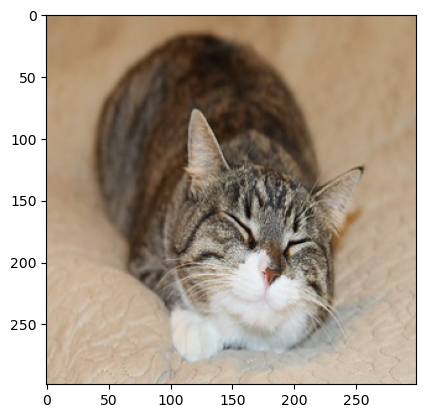

In [19]:
plt.imshow(data[0])

In [20]:
image_shape=(20,20,3)
predict_fn = lambda x: model.predict(x)
explainer = AnchorImage(predict_fn, image_shape,
                              segmentation_fn='slic',images_background=None)

1/1 [==============================] - 1s 762ms/step


4/4 [==============================] - 4s 970ms/step


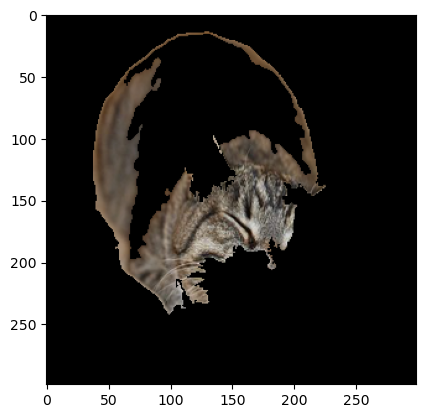

In [21]:
image = images[0]
np.random.seed(0)
explanation = explainer.explain(image, threshold=.95, p_sample=.5, tau=0.25)

plt.imshow(explanation.anchor)

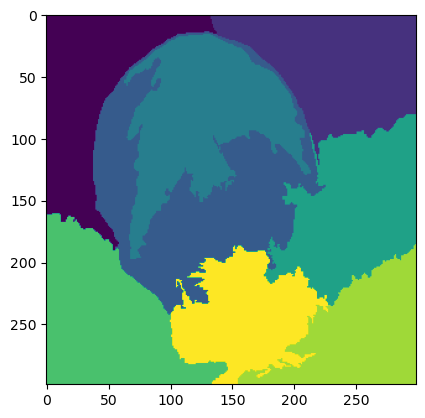

In [22]:
plt.imshow(explanation.segments)